# Image Segementation and the Watershed Algorithm

Our challenge here will be read each coin separatly. This is a challange due to the coins are connected and we can not use contours because it is being seen as an unique image. To overcome this challenge we will use the Watershed algo

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pyimagesearch.imageutils import display

## Naive Approach

Let's try to simply use a threshold and then use findContours.

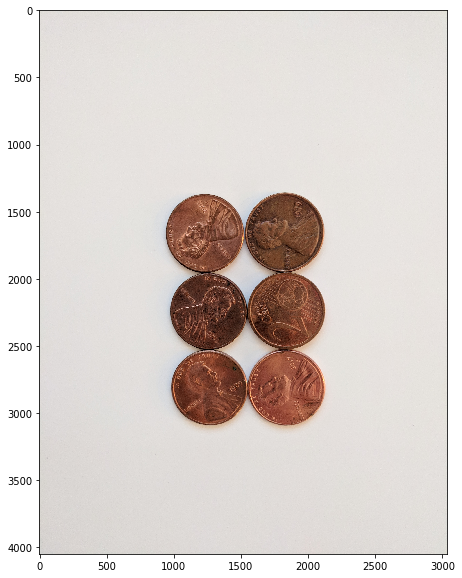

In [2]:
sep_coins = cv2.imread('images/pennies.jpg')
display(sep_coins)

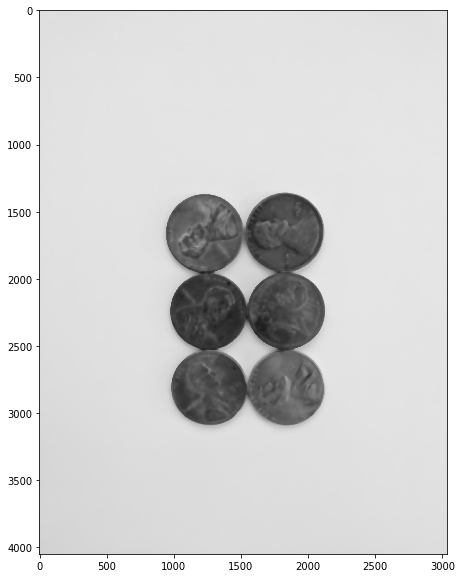

In [3]:
# We have too much detail in this image, including light, the face edges on the coins, and too much detail in the 
# background. Let's use Median Blur Filtering to blur the image a bit, which will be useful later on when we threshold.
sep_blur = cv2.medianBlur(sep_coins,25)
gray_sep_coins = cv2.cvtColor(sep_blur,cv2.COLOR_BGR2GRAY)
display(gray_sep_coins,cmap='gray')

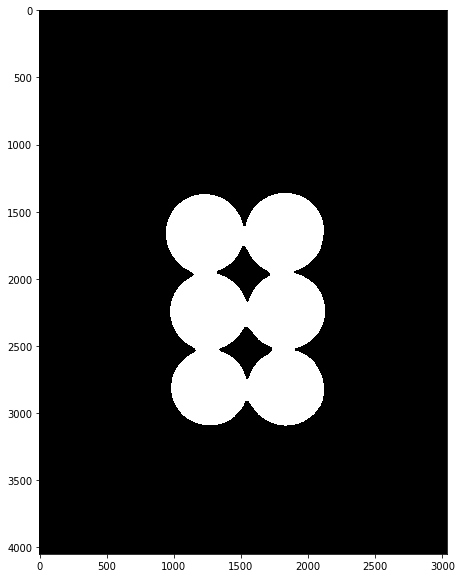

In [4]:
ret, sep_thresh = cv2.threshold(gray_sep_coins,160,255,cv2.THRESH_BINARY_INV)
display(sep_thresh,cmap='gray')

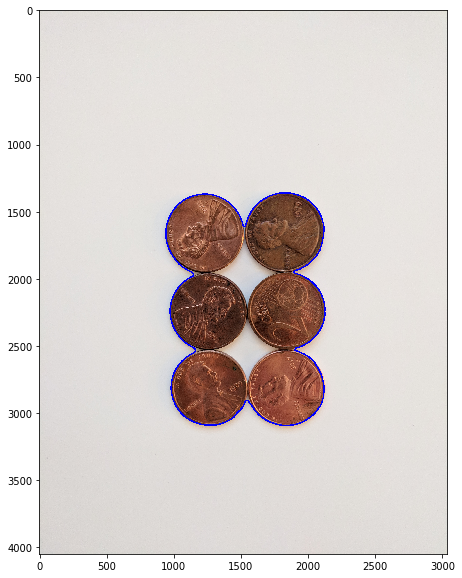

In [5]:
# Finding contours
contours, hierarchy = cv2.findContours(sep_thresh.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
# For every entry in contours
for i in range(len(contours)):
    
    # last column in the array is -1 if an external contour (no contours inside of it)
    if hierarchy[0][i][3] == -1:
        
        # We can now draw the external contours from the list of contours
        cv2.drawContours(sep_coins, contours, i, (255, 0, 0), 10)
display(sep_coins)

# Watershed Algorithm

Let's now try the watershed algorithm apporach to draw contours around the pennies

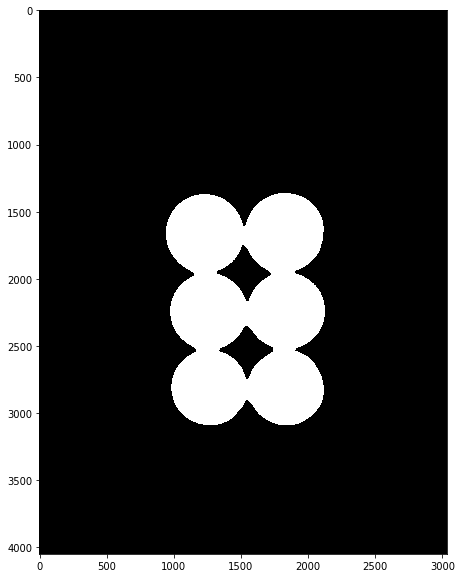

In [6]:
img = cv2.imread('images/pennies.jpg')
img = cv2.medianBlur(img,35)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

display(thresh,cmap='gray')

### Optional Step 5: Noise Removal

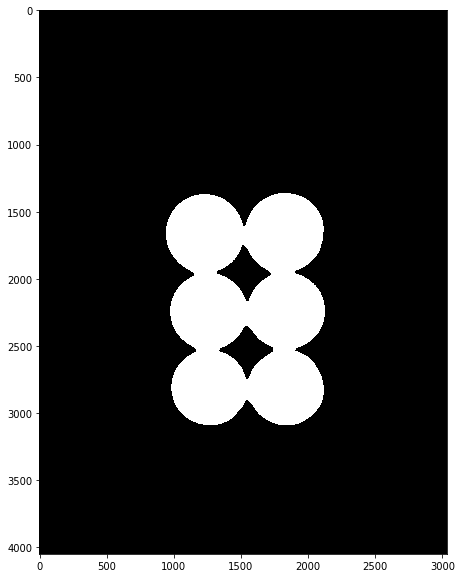

In [7]:
# # noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
display(opening,cmap='gray')

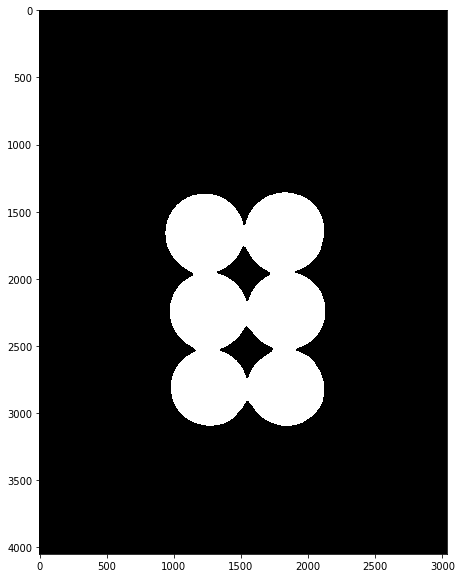

In [8]:
# Grab Background that you are sure of
sure_bg = cv2.dilate(opening,kernel,iterations=3)
display(sure_bg,cmap='gray')

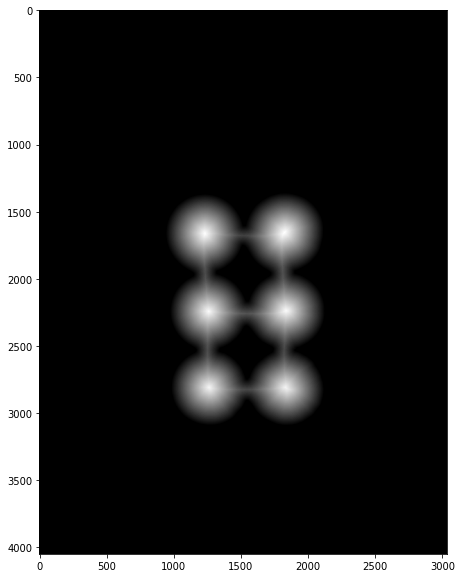

In [9]:
# Finding foreground area
# we use this fading approach which make the area close to the black daker and the brither in the center
# this wahy we can for sure unglue the coins using the threshold
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
display(dist_transform,cmap='gray',bgr2rgb=False)


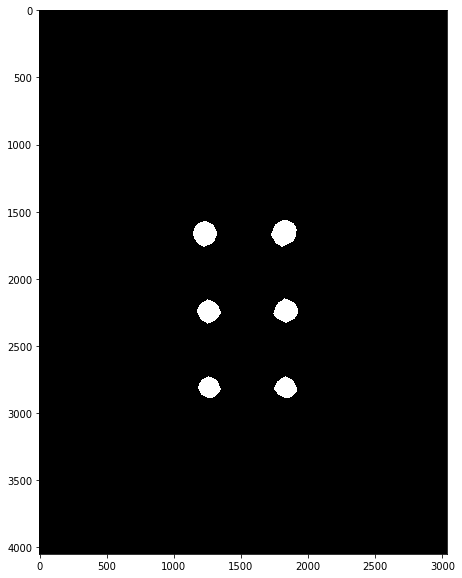

In [10]:
# Making sure we separate each element using a threshold. 
# 70% of the max bright upt to 255 will be white and the remainng will be black
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
display(sure_fg,cmap='gray',bgr2rgb=False)

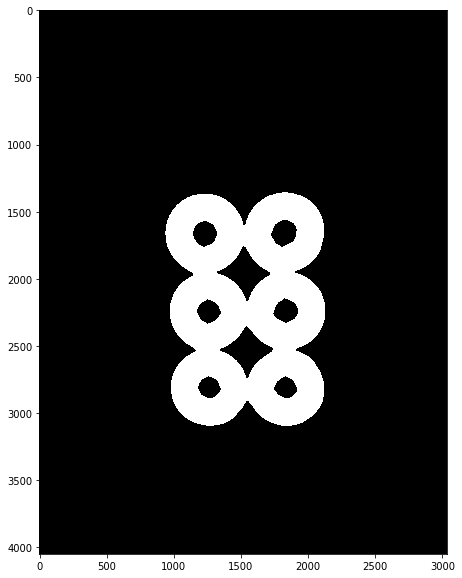

In [11]:
# Finding unknown region
# checking how much the 2  picture differs from the each other
# with this operation we have the area tha we are sure are part of each coing (black) 
# but the white area still connected and we are not able to unplug yet
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
display(unknown,cmap='gray',bgr2rgb=False)

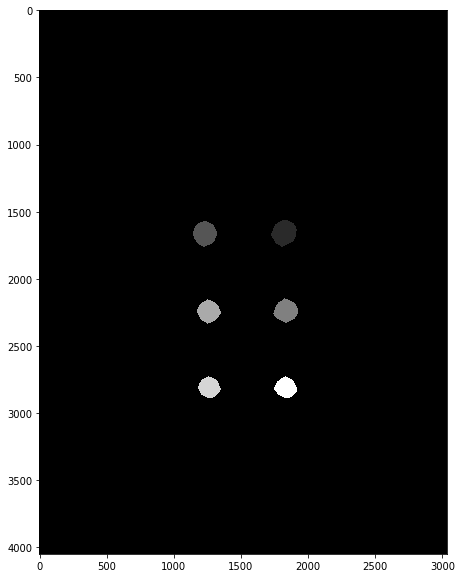

In [12]:
from pyimagesearch.imageutils import display

# This gives a different collor to each area
ret, markers = cv2.connectedComponents(sure_fg)
display(markers,cmap='gray',bgr2rgb=False)

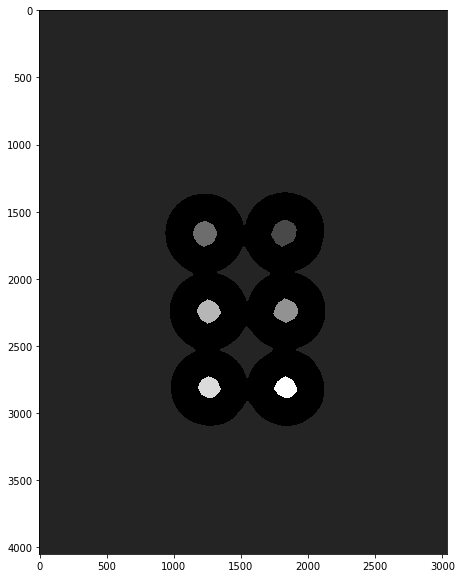

In [13]:
# Add 1 to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
display(markers,cmap='gray',bgr2rgb=False)

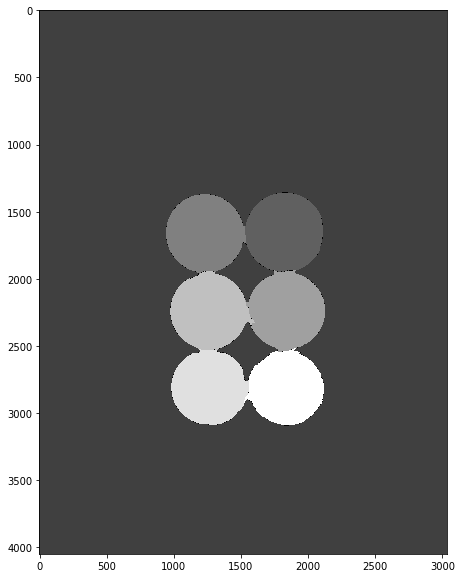

In [14]:
# Apply Watershed Algorithm to find Markers
markers = cv2.watershed(img, markers)
display(markers,'gray', False)

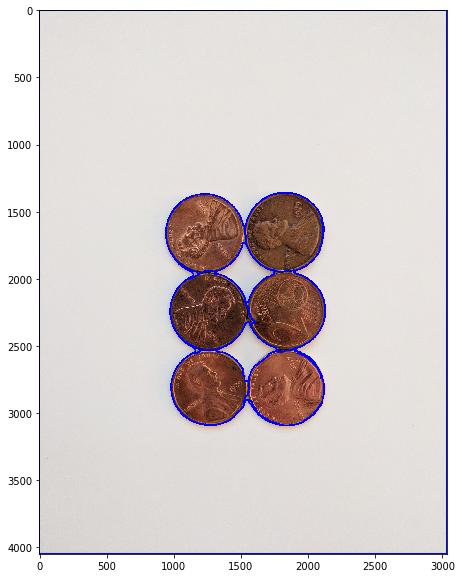

In [15]:

# Now we can use contours safely
contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# For every entry in contours
for i in range(len(contours)):
    
    # last column in the array is -1 if an external contour (no contours inside of it)
    if hierarchy[0][i][3] == -1:
        
        # We can now draw the external contours from the list of contours
        cv2.drawContours(sep_coins, contours, i, (255, 0, 0), 10)
display(sep_coins)        